In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse

from fbprophet import Prophet

In [2]:
### READ DATA ###

df = pd.read_parquet('est_hourly.paruqet')
df = df.groupby(level=0).first()
df = df.asfreq('H')

print(df.shape)
df.head()

(178296, 12)


,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-04-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259.0
1998-04-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21244.0
1998-04-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20651.0
1998-04-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20421.0
1998-04-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20713.0


<AxesSubplot:xlabel='Datetime'>

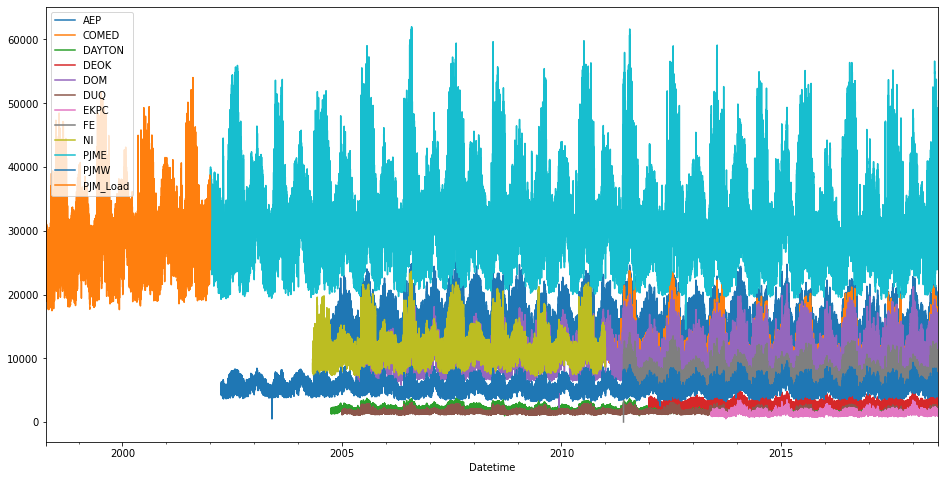

In [3]:
### PLOT THE CONSUMPTIONS IN EACH REGION ###

df.plot(figsize=(16,8))

<AxesSubplot:title={'center':'PJME - Seasonal Trends'}, xlabel='Hours', ylabel='MW'>

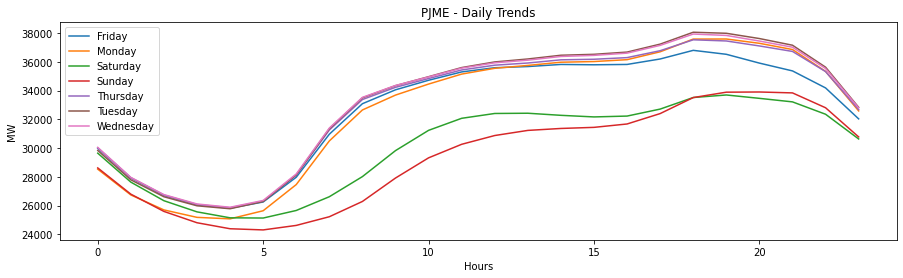

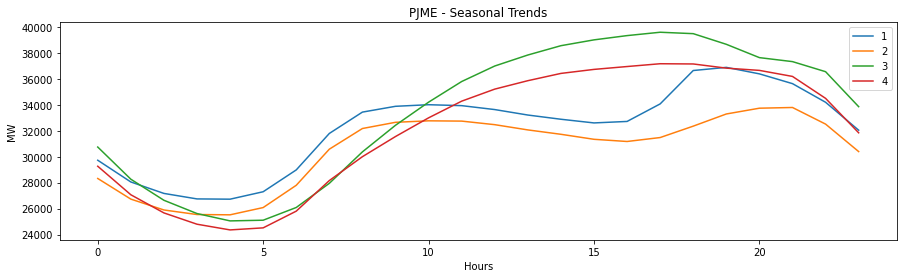

In [4]:
### PLOT WEEKLY AND SEASONAL PATTERNS BY DAILY HOURS ###

df.pivot_table(
    index=df.index.hour.values, 
    columns=df.index.day_name().values, 
    values='PJME',
    aggfunc='mean'
).plot(figsize=(15,4), title='PJME - Daily Trends', ylabel='MW', xlabel='Hours')

df.pivot_table(
    index=df.index.hour.values, 
    columns=((df.index.month +1)%12 // 3 + 1).values, 
    values='PJME',
    aggfunc='mean'
).plot(figsize=(15,4), title='PJME - Seasonal Trends', ylabel='MW', xlabel='Hours')

In [5]:
### CYCLICAL ENCODING VARIABLES ###

def cyclic_encoding(df, col):
    
    max_val = df[col].max()
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    
    return df.drop([col], axis=1)


X = df.drop(df.columns, axis=1)
X['Hour'] = X.index.hour
X = cyclic_encoding(X, 'Hour')
X['DayOfWeek'] = X.index.dayofweek
X = cyclic_encoding(X, 'DayOfWeek')
X['WeekOfYear'] = X.index.isocalendar().week
X = cyclic_encoding(X, 'WeekOfYear')
X['Month'] = X.index.month
X = cyclic_encoding(X, 'Month')
X['Season'] = (X.index.month +1)%12 // 3 + 1
X = cyclic_encoding(X, 'Season')

X.shape

(178296, 10)

In [6]:
### TRAIN TEST SPLIT ###

Y = df['PJME']

y_test = Y.tail(365*24).interpolate(limit_direction='both')
y_train = Y[~df.index.isin(y_test.index)].tail(365*24*3).interpolate(limit_direction='forward').dropna()

X_train = X.loc[y_train.index]
X_test = X.loc[y_test.index]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26280, 10), (8760, 10), (26280,), (8760,))

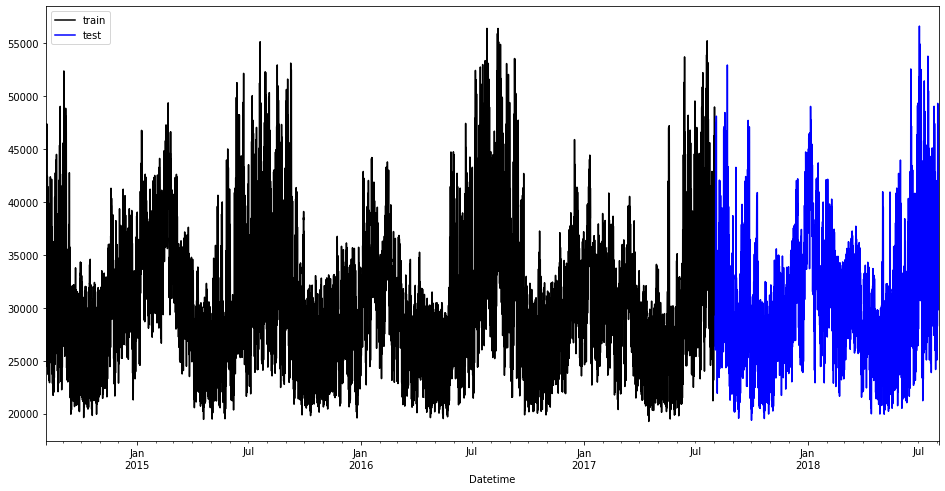

In [7]:
### PLOT TRAIN AND TEST ###

y_train.plot(figsize=(16,8), label='train', c='black')
y_test.plot(figsize=(16,8), label='test', c='blue')
plt.legend()

# Forecasting Multiple Seasonalities

In [8]:
### FIT PROPHET ###

prophet = Prophet()
prophet.fit(y_train.reset_index().rename(columns={'Datetime':'ds', y_train.name:'y'}))

pred_prophet = prophet.predict(y_test.reset_index().rename(columns={'Datetime':'ds'}).drop(y_test.name, axis=1))
pred_prophet = pred_prophet[['ds','yhat']].rename(columns={'ds':'Datetime'}).set_index('Datetime')['yhat']

print('\n\n', 'TEST ERROR:', mse(y_test, pred_prophet, squared=False))

Initial log joint probability = -199.336
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       58837.1   0.000624965       314.514           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         58930    0.00672231       1148.32       1.138      0.1138      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       58950.8   0.000658694       337.236      0.1974      0.1974      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       58961.8    0.00131378       733.887           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       58974.6     0.0159921        569.66       1.446      0.1446      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

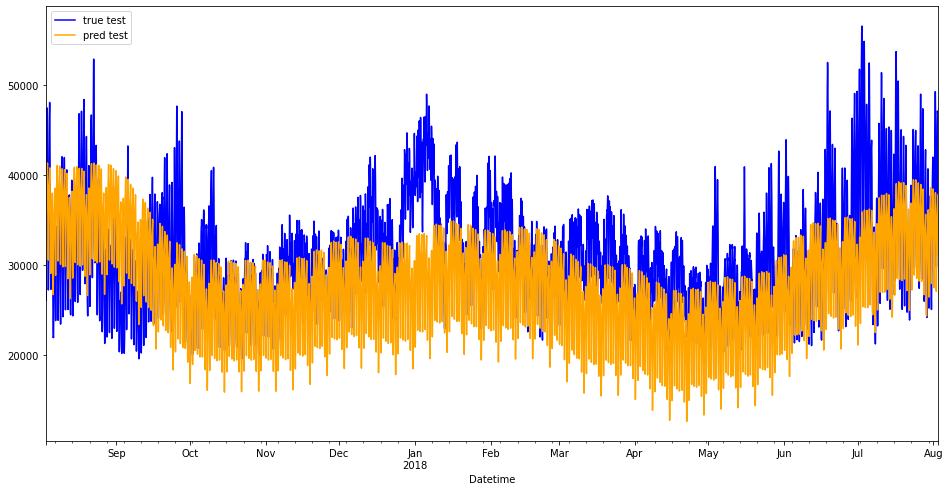

In [9]:
### PLOT PROPHET PREDICTIONS ###

y_test.plot(figsize=(16,8), label='true test', c='blue')
pred_prophet.plot(figsize=(16,8), label='pred test', c='orange')
plt.legend()

In [10]:
### TRAIN GRADIENT BOOSTING ###

boosting = GridSearchCV(estimator=GradientBoostingRegressor(random_state=33), 
                     param_grid={'max_depth': [8, 10, 12, None], 'n_estimators': [10, 20, 30]}, 
                     scoring='neg_mean_squared_error', cv=3, refit=True, n_jobs=-1)
boosting.fit(X_train, y_train)

pred_boosting = pd.Series(boosting.predict(X_test), index=y_test.index)

print('\n', 'TEST ERROR:', mse(y_test, pred_boosting, squared=False))


 TEST ERROR: 4083.520288165716


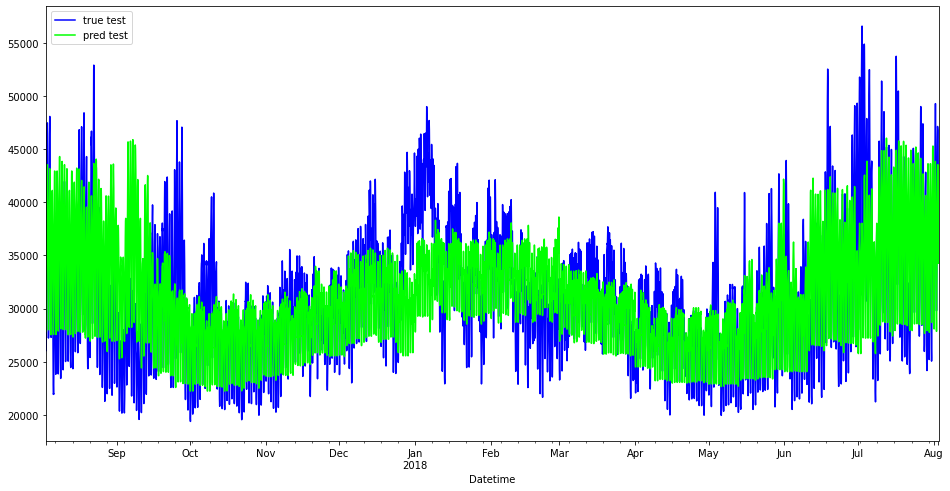

In [11]:
### PLOT GRADIENT BOOSTING PREDICTIONS ###

y_test.plot(figsize=(16,8), label='true test', c='blue')
pred_boosting.plot(figsize=(16,8), label='pred test', c='lime')
plt.legend()

# Forecasting Multiple Seasonalities + Trend

In [12]:
### GENERATE AND ADD TREND TO ORIGINAL DATA ###

x = np.linspace(-1, 1, X_train.shape[0]+X_test.shape[0])
trend = np.log(1 + np.exp(2 * x))
trend /= trend.max()*3
trend += 1
trend = pd.Series(trend, index=np.r_[y_train.index, y_test.index])

y_train_trend = y_train*trend.iloc[:y_train.shape[0]]
y_train_trend.name = y_train.name
y_test_trend = y_test*trend.iloc[y_train.shape[0]:]
y_test_trend.name = y_test.name

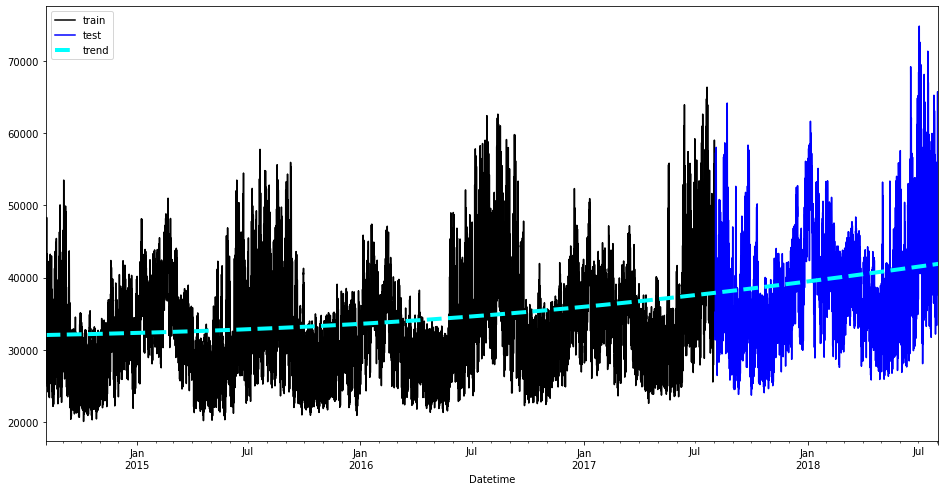

In [13]:
### PLOT TRAIN AND TEST ###

y_train_trend.plot(figsize=(16,8), label='train', c='black')
y_test_trend.plot(figsize=(16,8), label='test', c='blue')
(trend*Y.median()).plot(figsize=(16,8), c='cyan', linewidth=4, style='--', label='trend')
plt.legend()

In [14]:
### FIT PROPHET ###

prophet = Prophet()
prophet.fit(y_train_trend.reset_index().rename(columns={'Datetime':'ds', y_train_trend.name:'y'}))

pred_prophet = prophet.predict(y_test_trend.reset_index().rename(columns={'Datetime':'ds'}).drop(y_test.name, axis=1))
pred_prophet = pred_prophet[['ds','yhat']].rename(columns={'ds':'Datetime'}).set_index('Datetime')['yhat']

print('\n\n', 'TEST ERROR:', mse(y_test_trend, pred_prophet, squared=False))

Initial log joint probability = -162.709
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       60687.4    0.00150922       833.648           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       60793.2     0.0249404       2983.32      0.8941      0.8941      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       60814.1    0.00105153       369.642           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         60835     0.0525531       1561.97           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       60842.8     0.0104121       2452.42      0.7165      0.7165      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

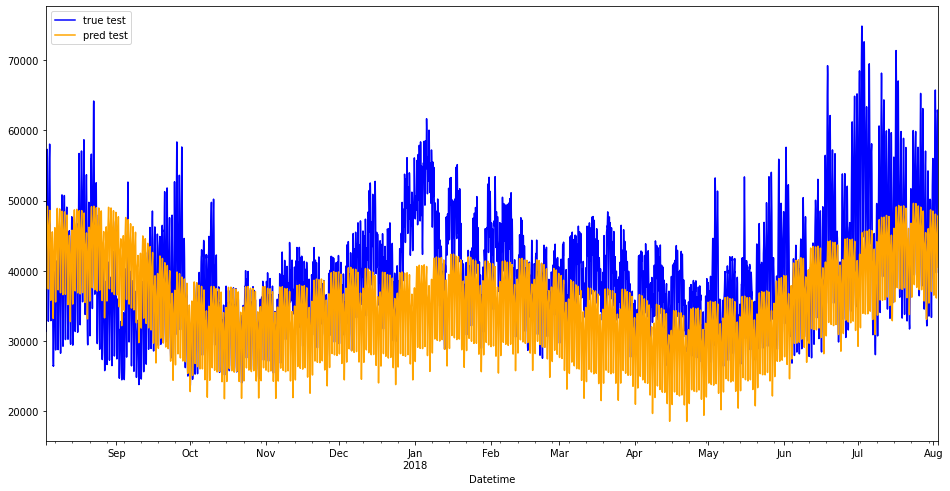

In [15]:
### PLOT PROPHET PREDICTIONS ###

y_test_trend.plot(figsize=(16,8), label='true test', c='blue')
pred_prophet.plot(figsize=(16,8), label='pred test', c='orange')
plt.legend()

In [16]:
### CREATE TREND FEATURES ###

trend_train = np.arange(0,X_train.shape[0]).reshape(-1,1)
trend_test = np.arange(X_train.shape[0], X_train.shape[0]+X_test.shape[0]).reshape(-1,1)

X_train_trend = np.power(trend_train, [1,2])
X_test_trend = np.power(trend_test, [1,2])

In [17]:
### FIT LINEAR REGRESSION TO PREDICT TREND ###

linear_reg = LinearRegression()
linear_reg.fit(X_train_trend, y_train_trend)

pred_train_trend = pd.Series(linear_reg.predict(X_train_trend), index=y_train_trend.index)
pred_test_trend = pd.Series(linear_reg.predict(X_test_trend), index=y_test_trend.index)

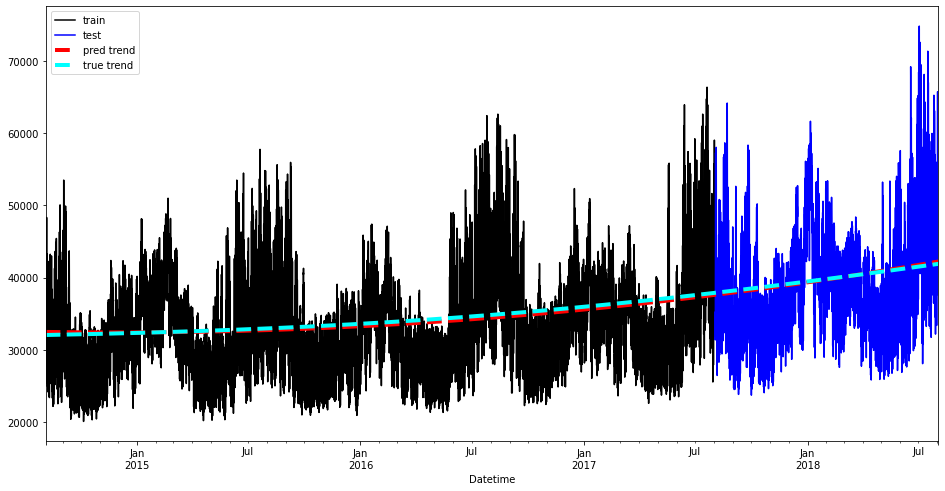

In [18]:
### PLOT PREDICTED TREND ###

y_train_trend.plot(figsize=(16,8), label='train', c='black')
y_test_trend.plot(figsize=(16,8), label='test', c='blue')
pd.concat([pred_train_trend, pred_test_trend]).plot(figsize=(16,8), c='red', linewidth=4, style='--', label='pred trend')
(trend*Y.median()).plot(figsize=(16,8), c='cyan', linewidth=4, style='--', label='true trend')
plt.legend()

In [19]:
### TRAIN GRADIENT BOOSTING ###

boosting = GridSearchCV(estimator=GradientBoostingRegressor(random_state=33), 
                     param_grid={'max_depth': [8, 10, 12, None], 'n_estimators': [10, 20, 30]}, 
                     scoring='neg_mean_squared_error', cv=3, refit=True, n_jobs=-1)
boosting.fit(X_train, y_train_trend-pred_train_trend)

pred_boosting = pd.Series(boosting.predict(X_test)+pred_test_trend, index=y_test_trend.index)

print('\n', 'TEST ERROR:', mse(y_test_trend, pred_boosting, squared=False))


 TEST ERROR: 5162.132906323343


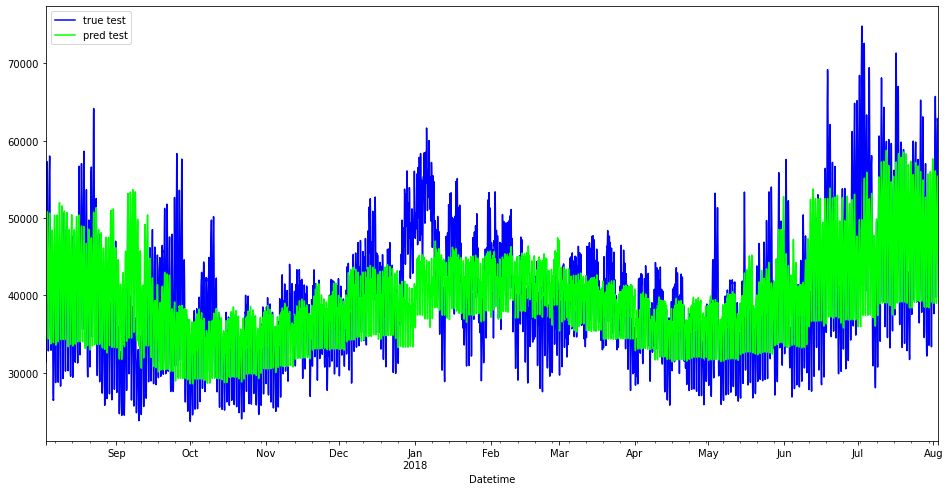

In [20]:
### PLOT GRADIENT BOOSTING PREDICTIONS ###

y_test_trend.plot(figsize=(16,8), label='true test', c='blue')
pred_boosting.plot(figsize=(16,8), label='pred test', c='lime')
plt.legend()